#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  return np.mean(np.log(1 + np.exp(-y * (X.dot(w) + w0)))) + gamma * np.linalg.norm(w, ord=1) + beta * np.linalg.norm(w, ord=2)

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    grad_w = (-1 / X.shape[0]) * ((y[:, None] * X) / (1 + np.exp(y * (X.dot(w) + w0)))[:, None]).sum(axis=0) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = (-1 / X.shape[0]) * (y[:, None] / (1 + np.exp(y * (X.dot(w) + w0)))[:, None]).sum(axis=0)

    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w, self.w0 = None, None
        self.loss_hist = []

    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.w = np.random.randn(X.shape[1])
        self.w0 = np.random.randn(1)[0]
        for _ in tqdm(range(self.max_iter)):
            curr_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_hist.append(curr_loss)
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            temp_lst = list(grad_w)
            temp_lst.append(grad_w0[0])

            if np.linalg.norm(temp_lst, ord=2) < self.tolerance: break

    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        if (self.w is None) or (self.w0 is None):
            print("ERROR! The model has not been trained!")
            return

        probs = self.predict_proba(X)
        return (probs > 0.5).astype(int)

    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        if (self.w is None) or (self.w0 is None):
            print("ERROR! The model has not been trained!")
            return

        return 1 / (1 + np.exp(-(X.dot(self.w) + self.w0)))

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y)

    plt.title('LogReg boundary')
    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 4739.14it/s]


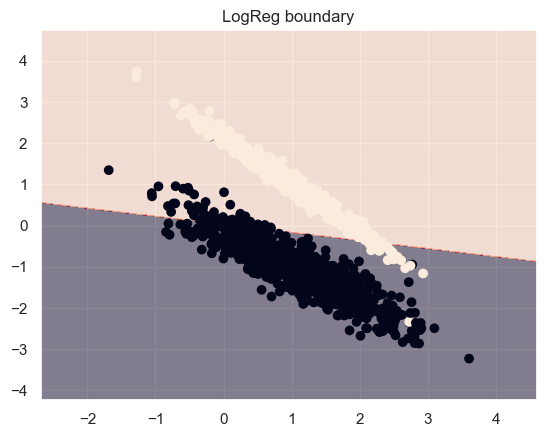

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    loss_hist = model.loss_hist
    plt.title('Loss history')
    plt.plot(loss_hist)

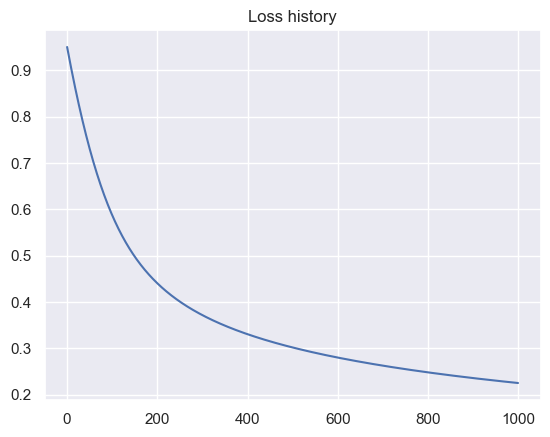

In [11]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


svc_model = SVC()

svc_model.fit(X, y)

svc_preds = svc_model.predict(X)

print(f"Accuracy: {accuracy_score(y, svc_preds)}")
print(f"Precision: {precision_score(y, svc_preds)}")
print(f"Recall: {recall_score(y, svc_preds)}")
print(f"F1: {f1_score(y, svc_preds)}")
print(f"AUC-ROC: {roc_auc_score(y, svc_preds)}")

Accuracy: 0.9961111111111111
Precision: 0.9955555555555555
Recall: 0.996662958843159
F1: 0.9961089494163424
AUC-ROC: 0.9961117235947204


In [13]:
svc_model = SVC(C=10)

svc_model.fit(X, y)

svc_preds = svc_model.predict(X)

print(f"Accuracy: {accuracy_score(y, svc_preds)}")
print(f"Precision: {precision_score(y, svc_preds)}")
print(f"Recall: {recall_score(y, svc_preds)}")
print(f"F1: {f1_score(y, svc_preds)}")
print(f"AUC-ROC: {roc_auc_score(y, svc_preds)}")

Accuracy: 0.9961111111111111
Precision: 0.9955555555555555
Recall: 0.996662958843159
F1: 0.9961089494163424
AUC-ROC: 0.9961117235947204


In [14]:
svc_model = SVC(C=0.1)

svc_model.fit(X, y)

svc_preds = svc_model.predict(X)

print(f"Accuracy: {accuracy_score(y, svc_preds)}")
print(f"Precision: {precision_score(y, svc_preds)}")
print(f"Recall: {recall_score(y, svc_preds)}")
print(f"F1: {f1_score(y, svc_preds)}")
print(f"AUC-ROC: {roc_auc_score(y, svc_preds)}")

Accuracy: 0.9961111111111111


Precision: 0.9955555555555555
Recall: 0.996662958843159
F1: 0.9961089494163424
AUC-ROC: 0.9961117235947204


In [15]:
svc_model = SVC(kernel="linear")

svc_model.fit(X, y)

svc_preds = svc_model.predict(X)

print(f"Accuracy: {accuracy_score(y, svc_preds)}")
print(f"Precision: {precision_score(y, svc_preds)}")
print(f"Recall: {recall_score(y, svc_preds)}")
print(f"F1: {f1_score(y, svc_preds)}")
print(f"AUC-ROC: {roc_auc_score(y, svc_preds)}")

Accuracy: 0.9955555555555555
Precision: 0.9944506104328524
Recall: 0.996662958843159
F1: 0.9955555555555555
AUC-ROC: 0.9955567846380058


In [16]:
svc_model = SVC(kernel="poly")

svc_model.fit(X, y)

svc_preds = svc_model.predict(X)

print(f"Accuracy: {accuracy_score(y, svc_preds)}")
print(f"Precision: {precision_score(y, svc_preds)}")
print(f"Recall: {recall_score(y, svc_preds)}")
print(f"F1: {f1_score(y, svc_preds)}")
print(f"AUC-ROC: {roc_auc_score(y, svc_preds)}")

Accuracy: 0.9961111111111111
Precision: 0.9955555555555555
Recall: 0.996662958843159
F1: 0.9961089494163424
AUC-ROC: 0.9961117235947204


In [17]:
svc_model = SVC(kernel="sigmoid")

svc_model.fit(X, y)

svc_preds = svc_model.predict(X)

print(f"Accuracy: {accuracy_score(y, svc_preds)}")
print(f"Precision: {precision_score(y, svc_preds)}")
print(f"Recall: {recall_score(y, svc_preds)}")
print(f"F1: {f1_score(y, svc_preds)}")
print(f"AUC-ROC: {roc_auc_score(y, svc_preds)}")

Accuracy: 0.9394444444444444
Precision: 0.9488636363636364
Recall: 0.92880978865406
F1: 0.9387296233839235
AUC-ROC: 0.9394326412748658


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [18]:
from collections import  Counter
from tqdm import tqdm


class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidian'):
        self.n_neighbors = n_neighbors
        if metric == "euclidian":
            self.metric = lambda x: np.linalg.norm(x)
        else:
            self.metric = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        res_y_lst = []
        for idx_test in tqdm(range(X.shape[0])):
            temp_lst = []
            for idx_train in range(self.X_train.shape[0]):
                #print()
                temp_lst.append(self.metric(X[idx_test] - self.X_train[idx_train]))
            idx_neighbours = np.argsort(temp_lst)[:self.n_neighbors]
            temp_temp = self.y_train[idx_neighbours]
            #print(temp_temp)
            res_y_lst.append([
                float((temp_temp == 0).sum() / self.n_neighbors),
                float((temp_temp == 1).sum() / self.n_neighbors)
                ])
        return res_y_lst

In [19]:
knn_model = KNNClassifier(n_neighbors=5)

knn_model.fit(X, y)

knn_preds = knn_model.predict(X)
knn_preds[knn_preds == 0] = -1

print(f"Accuracy: {accuracy_score(y, knn_preds)}")
print(f"Precision: {precision_score(y, knn_preds)}")
print(f"Recall: {recall_score(y, knn_preds)}")
print(f"F1: {f1_score(y, knn_preds)}")
print(f"AUC-ROC: {roc_auc_score(y, knn_preds)}")

100%|██████████| 1800/1800 [00:12<00:00, 149.14it/s]

Accuracy: 0.9905555555555555
Precision: 0.9814410480349345
Recall: 1.0
F1: 0.990633608815427
AUC-ROC: 0.9905660377358491


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [20]:
df_train = pd.read_csv("./fashion_mnist/fashion-mnist_train.csv")
df_test = pd.read_csv("./fashion_mnist/fashion-mnist_test.csv")

In [21]:
print(len(df_train))
print(len(df_test))

60000
10000


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

In [22]:
set(df_train.label.values)

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9)}

In [23]:
from random import randint

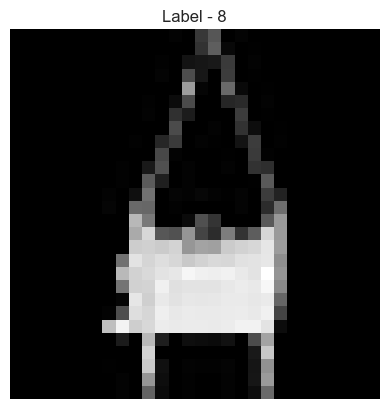

In [24]:
def print_random_img(df, lbl=None):
  if lbl is None:
    lbl = randint(0, 9)
  df = df[df.label == lbl].sample(1)
  image = df.iloc[0, 1:].values.reshape(28, 28)
  plt.imshow(image, cmap='gray')
  plt.title(f"Label - {lbl}")
  plt.axis('off')
  plt.show()


print_random_img(df_train)

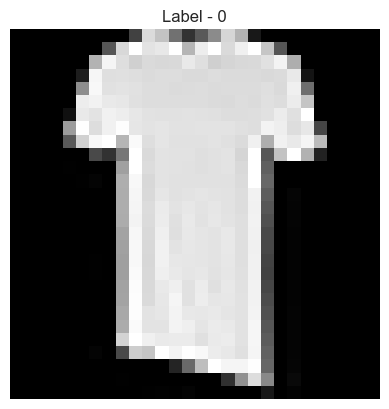

In [25]:
print_random_img(df_train, lbl=0)

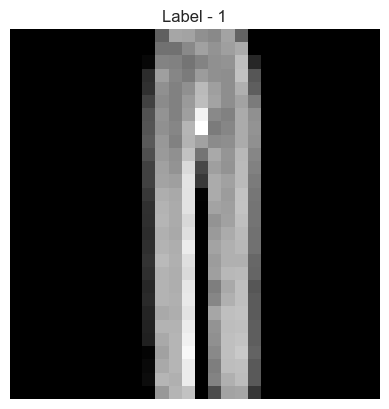

In [26]:
print_random_img(df_train, lbl=1)

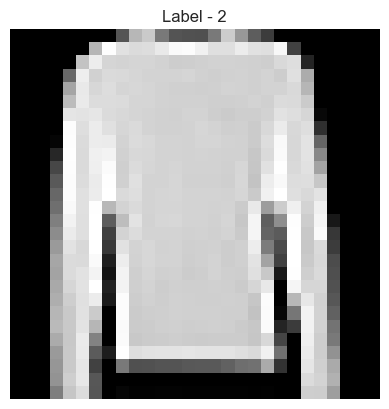

In [27]:
print_random_img(df_train, lbl=2)

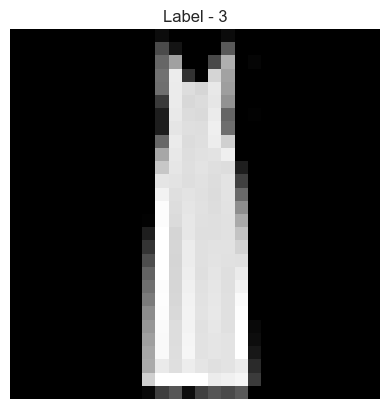

In [28]:
print_random_img(df_train, lbl=3)

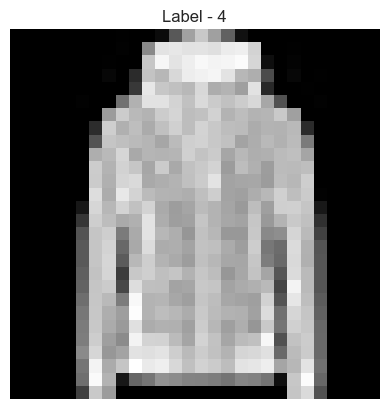

In [29]:
print_random_img(df_train, lbl=4)

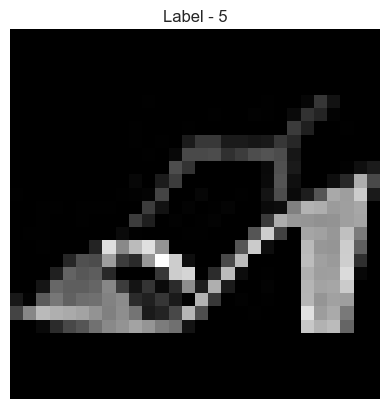

In [30]:
print_random_img(df_train, lbl=5)

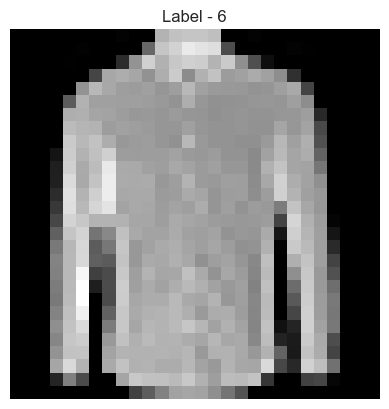

In [31]:
print_random_img(df_train, lbl=6)

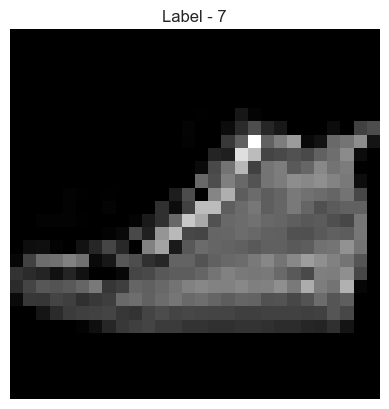

In [32]:
print_random_img(df_train, lbl=7)

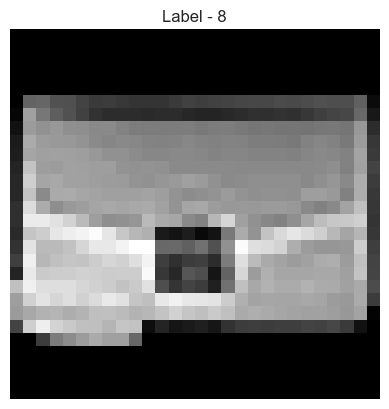

In [33]:
print_random_img(df_train, lbl=8)

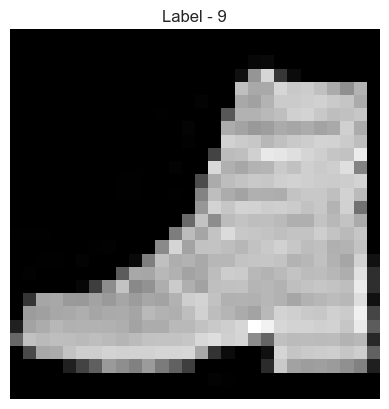

In [34]:
print_random_img(df_train, lbl=9)

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [36]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
X_test_mm = mm.transform(X_test)

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [38]:
# для поиска по сетке выбираются основные параметры, влияющие на качество логистической регресси -
# виды регуляризации, коэффициент регуляризации и оптимизатор
params_lr = {'penalty':['l1', 'l2'], 'C':[1, 10, 25], "solver": ["lbfgs", "sag"], "max_iter": [100]}

# для поиска по сетке выбираются основные параметры, влияющие на качество к ближайших соседей -
# количество соседей и способ подсчета расстояния между ними
params_knn = {'n_neighbors':[3, 7], "p": [1, 2]}

ВСЕ ГОТОВО, НО ЗАПУСТИТЬ НЕ УСПЕЛ((

Попробуем работать с признаками после StandardScaler

In [ ]:
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params_knn, cv=5, verbose=2, scoring="accuracy")
clf.fit(X_train_ss, y_train)

estimator = clf.best_estimator_
preds = estimator.predict(X_test_ss)
print(f"Accuracy: {accuracy_score(y_test, preds)}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
lr = LogisticRegression()
clf = GridSearchCV(lr, params_lr, cv=5, verbose=2, scoring="accuracy")
clf.fit(X_train_ss, y_train)

estimator = clf.best_estimator_
preds = estimator.predict(X_test_ss)
print(f"Accuracy: {accuracy_score(y_test, preds)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.2s
[CV] END ..........C=1, max_iter=100, penalty=l1, solver=sag; total time=   0.1s
[CV] END ..........C=1, max_iter=100, penalty=l1, solver=sag; total time=   0.1s
[CV] END ..........C=1, max_iter=100, penalty=l1, solver=sag; total time=   0.1s
[CV] END ..........C=1, max_iter=100, penalty=l1, solver=sag; total time=   0.2s
[CV] END ..........C=1, max_iter=100, penalty=l1, solver=sag; total time=   0.1s


c:\Users\DungeonMaster3000\Desktop\ml_hw\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=  12.7s


c:\Users\DungeonMaster3000\Desktop\ml_hw\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=  12.4s


c:\Users\DungeonMaster3000\Desktop\ml_hw\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=  13.9s


c:\Users\DungeonMaster3000\Desktop\ml_hw\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=  14.1s


c:\Users\DungeonMaster3000\Desktop\ml_hw\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=  12.6s


c:\Users\DungeonMaster3000\Desktop\ml_hw\venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=100, penalty=l2, solver=sag; total time= 2.0min


c:\Users\DungeonMaster3000\Desktop\ml_hw\venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=100, penalty=l2, solver=sag; total time= 1.9min


c:\Users\DungeonMaster3000\Desktop\ml_hw\venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=100, penalty=l2, solver=sag; total time= 1.9min


Попробуем работать с признаками после MinMaxScaler

In [ ]:
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params_knn, cv=5, verbose=2, scoring="accuracy")
clf.fit(X_train_mm, y_train)

estimator = clf.best_estimator_
preds = estimator.predict(X_test_mm)
print(f"Accuracy: {accuracy_score(y_test, preds)}")

In [ ]:
lr = LogisticRegression()
clf = GridSearchCV(lr, params_lr, cv=5, verbose=2, scoring="accuracy")
clf.fit(X_train_mm, y_train)

estimator = clf.best_estimator_
preds = estimator.predict(X_test_mm)
print(f"Accuracy: {accuracy_score(y_test, preds)}")

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.